# Data Processing

For every sensor we regularly receive data in the format
$$ \left( a_x, a_y, a_z, g_x, g_y, g_z \right) $$
where $a_x, a_y, a_z$ are acceleration in their respective directions and $g_x, g_y, g_z$ are yaw, pitch and roll respectively.

In addition, for the training data we have information about the current state of tapping, if the finger is currenly on the table or not. In practice the predictions can be used to get a estimation for the current state of tapping.

## Parse Data

For training there are two ways for us to receive the necessary data
1. from records stored on the SD card on the main boards and
2. live through a serial interface when the main board is connected to the PC.

### From Record

The file that is stored on the main board is of some format `data-*.txt`. Every line is either of the already discussed format or contains `v` or `^` to indicate that the finger starts or stops touching the table respectively.

We start with parsing the file into a numpy array with suitable structure.

In [12]:
import numpy as np

FILENAME = "data/data-test/data.txt"
SENSOR_COUNT = 6
SENSOR_VALUE_COUNT = 6

with open(FILENAME, 'r') as file:
    lines = file.read().strip().split('\n')

    # list of all readings
    all_readings = []
    # state of tapping
    pressing = False
    for line in lines:
        # check for change in state of tapping
        if "nt" in line: # TODO: change to "v"
            pressing = False
            continue
        elif "t" in line:
            pressing = True
            continue
            
        # one reading from all sensors (per line) flattened
        sensors = []
        for sensor_string in line.split(':'):
            # one sensor reading
            if sensor_string.count(';') != SENSOR_VALUE_COUNT-1:
                # set default values for non functional sensors
                sensors += [0, 0, 0, 0, 0, 0]
            else:
                sensors += [float(value) for value in sensor_string.split(';')]

        # add state of tapping to data entry
        sensors += [1 if pressing else 0]
        all_readings.append(sensors)

    data = np.array(all_readings)

### Through Serial

TODO

## Prepare Datasets

The datasets are formattings of the parsed data that can be passed to machine learning models as is.

To detect taps we try to strategies:
1. Detect press and release of taps separately. Easily extendable to holds.
2. Detect taps in one go.

The datasets will be saved using `joblib`.

In [13]:
from joblib import dump, load

# constants for press dataset
PRESS_BUFFER_SIZE = 3 # number of readings as input
PRESS_DATASET_FILENAME = "press_dataset.joblib"

# constats for release dataset
RELEASE_BUFFER_SIZE = 3
RELEASE_DATASET_FILENAME = "release_dataset.joblib"

FEATURE_NAMES = []

for reading in range(3):
    for sensor in range(6):
        for datum in ["acc_x", "acc_y", "acc_z","gyr_x", "gyr_y", "gyr_z"]:
            FEATURE_NAMES.append(f"[{reading-2}] {datum} ({sensor})")

### Press

This dataset will have `PRESS_BUFFER_SIZE` readings before and including the current reading in $X$ along with the tap state change (from not pressing to pressing) as output in $\mathbf{y}$.

In [14]:
PRESS_DATASET_SIZE = len(data)-(PRESS_BUFFER_SIZE-1)

# dataset declaration
press_dataset = (
    # X (input matrix)
    np.empty(shape = (
        PRESS_DATASET_SIZE,
        PRESS_BUFFER_SIZE * (SENSOR_COUNT * SENSOR_VALUE_COUNT)
    )),
    # y (output vector)
    np.empty(shape = PRESS_DATASET_SIZE)
)

# populate dataset with data
X = press_dataset[0]
y = press_dataset[1]
for index in np.arange(PRESS_DATASET_SIZE):
    for buffer_index in np.arange(PRESS_BUFFER_SIZE):
        size  = SENSOR_COUNT*SENSOR_VALUE_COUNT
        start = size*buffer_index
        end   = size*(buffer_index+1)
        X[index][start:end] = data[index+buffer_index][:size]
    # if change of tapping state in buffer (from not to tap)
    # set output to 1 otherwise 0
    y[index] = 1 if data[index+(PRESS_BUFFER_SIZE-1)][-1] - data[index+(PRESS_BUFFER_SIZE-2)][-1] == 1 else 0

# save dataset in PRPRESS_DATASET_FILENAME
dump(press_dataset, PRESS_DATASET_FILENAME)

['press_dataset.joblib']

### Release

This data set is like the press dataset but the output will only be one on a tap state change from pressing to not pressing (release).

In [24]:
RELEASE_DATASET_SIZE = len(data)-(RELEASE_BUFFER_SIZE-1)

# dataset declaration
release_dataset = (
    # X (input matrix)
    np.empty(shape = (
        RELEASE_DATASET_SIZE,
        RELEASE_BUFFER_SIZE * (SENSOR_COUNT * SENSOR_VALUE_COUNT)
    )),
    # y (output vector)
    np.empty(shape = RELEASE_DATASET_SIZE)
)

# populate dataset with data
X = release_dataset[0]
y = release_dataset[1]
for index in np.arange(RELEASE_DATASET_SIZE):
    for buffer_index in np.arange(RELEASE_BUFFER_SIZE):
        size  = SENSOR_COUNT*SENSOR_VALUE_COUNT
        start = size*buffer_index
        end   = size*(buffer_index+1)
        X[index][start:end] = data[index+buffer_index][:size]
    # if change of tapping state in buffer (from tap to not)
    # set output to 1 otherwise 0
    y[index] = 1 if data[index+(RELEASE_BUFFER_SIZE-1)][-1] - data[index+(RELEASE_BUFFER_SIZE-2)][-1] == -1 else 0

# save dataset in RELEASE_DATASET_FILENAME
dump(release_dataset, RELEASE_DATASET_FILENAME)

['release_dataset.joblib']

### Tap

TODO

# Machine Learning

## Dataset Preprocessing

### Dataset Splitting

To avoid overfitting in certain cases and generally improve validity the results the dataset will be split into a larger training dataset (67%) and a smaller testing dataset (33%). For now we will explicitly set `random_state` to improve reproducibility.

Additionally, to get a better idea of how practical the resulting model will be there will be two more datasets for scoring: one for the true positives rate, and one for the true negatives rate.

#### Press Dataset

In [15]:
from sklearn.model_selection import train_test_split
import numpy as np
from joblib import dump, load

# full dataset
X, y = load(PRESS_DATASET_FILENAME)

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.33, random_state = 100
)

# extended matrix
m = np.hstack((X_test, y_test.reshape((len(y_test),1))))

# only positives dataset
X_positive = m[m[:,-1] == 1, :-1]
y_positive = m[m[:,-1] == 1, -1]

# only negatives dataset
X_negative = m[m[:,-1] == 0, :-1]
y_negative = m[m[:,-1] == 0, -1]

#### Release Dataset

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np
from joblib import dump, load

# full dataset
X, y = load(RELEASE_DATASET_FILENAME)

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.33, random_state = 42
)

# extended matrix
m = np.hstack((X_test, y_test.reshape((len(y_test),1))))

# only positives dataset
X_positive = m[m[:,-1] == 1, :-1]
y_positive = m[m[:,-1] == 1, -1]

# only negatives dataset
X_negative = m[m[:,-1] == 0, :-1]
y_negative = m[m[:,-1] == 0, -1]

## Helper

Some potentially helpful helper functions. Collecting them here hopefully also increases readability.

### GridSearch

For easy hyperparameter tuning we use grid search. Since grid search is fairly expensive we determine four other scores alongside the f1-score which is used for finding the optimum.

All results should be saved in a dictionary in a file called `results.joblib`. The dictionary will have one entry per model type, e.g. `"Perceptron"` or `"LogisticRegression"`. Every of these entries will be another dictionary containing a mapping between the used tuple `(param_grid, scoring)` (the string of it actually) and the resulting trained classifier.

To achieve this the following function should be called after every grid search. Additionally if there are already results for the current execution the grid search function should respect that.

In [16]:
from joblib import dump, load
from os.path import exists
from sklearn.model_selection import ParameterGrid

RESULTS_FILE_NAME = "results.joblib"

def load_grid_search(model_key, scoring):
    if exists(RESULTS_FILE_NAME):
        storage = load(RESULTS_FILE_NAME)
        key = scoring
        if model_key in storage and key in storage[model_key]:
            return storage[model_key][key]
            
    return dict()


def prefix_param_grid(prefix, param_grid):
    if isinstance(param_grid, list):
        new_param_grid = []
        for sub_grid in param_grid:
            new_param_grid.append(
                prefix_param_grid(prefix, sub_grid)
            )

        return new_param_grid
    elif isinstance(param_grid, dict):
        new_param_grid = dict()
        for key, value in param_grid.items():
            new_param_grid[prefix + key] = value
            
        return new_param_grid
    else:
        return param_grid


def strip_param_grid(param_grid, storage):
    new_param_grid = []
    for param in ParameterGrid(param_grid):
        if not str(param) in storage:
            new_param = dict()
            for key, value in param.items():
                new_param[key] = [value]
                
            new_param_grid.append(new_param)

    return new_param_grid


def update_grid_search(storage, clf, scoring, refit):
    for index, param in enumerate(clf.cv_results_["params"]):
        param = str(param)
        if not param in storage:
            new_scores = []
            for score in scoring:
                score_key = "mean_test_"+score
                if score_key in clf.cv_results_:
                    new_scores.append(clf.cv_results_[score_key][index])
                else:
                    new_scores.apppend(np.nan)

            storage[param] = new_scores

    if refit in scoring:
        refit_index = scoring.index(refit)
        if "best" in storage:
            current_best = str(storage["best"])
            current_score = storage[current_best][refit_index]
            
            new_best = str(clf.best_params_)
            new_score = storage[new_best][refit_index]
    
            if new_score > current_score:
                storage["best"] = clf.best_params_
        else:
            storage["best"] = clf.best_params_
    else:
        print("Something went wrong: refit score not in scoring.")
        


def train_best_grid_search(model, storage):
    try:
        param = storage["best"]
        scores = storage[str(param)]
        model.set_params(**param)
        model.fit(X_train, y_train)
        return scores
    except Exception as e:
        print("Could not determine best model:", e)
        return []


def save_grid_search(model_key, scoring, storage):
    if exists(RESULTS_FILE_NAME):
        database = load(RESULTS_FILE_NAME)
    else:
        database = dict()

    if not model_key in database:
        database[model_key] = dict()

    database[model_key][scoring] = storage

    dump(database, RESULTS_FILE_NAME)

Now the actual implementation of the grid search wrapper.

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
import warnings

SCORING = ("accuracy", "precision", "recall", "balanced_accuracy", "f1")
REFIT = "f1"

def run_grid_search(model, initial_param_grid):
    pipe = Pipeline(steps=[
        ("scaler", StandardScaler()), 
        ("model", model)
    ])

    model_key = str(pipe)
    
    storage = load_grid_search(model_key, SCORING)

    param_grid = strip_param_grid(
        prefix_param_grid("model__", initial_param_grid),
        storage
    )

    print(f"Processing {len(param_grid)} of {len(ParameterGrid(initial_param_grid))} fits.")
    
    clf = GridSearchCV(
        estimator = pipe,
        param_grid = param_grid,
        scoring = SCORING,
        n_jobs = -1,
        refit = REFIT,
        verbose = 1
    )

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        if len(param_grid) > 0:
            clf.fit(X_train, y_train)
            
            update_grid_search(storage, clf, SCORING, REFIT)
    
    best_clf = Pipeline(steps=[
        ("scaler", StandardScaler()), 
        ("model", model)
    ])
    scores = train_best_grid_search(best_clf, storage)

    print(storage["best"])
    save_grid_search(model_key, SCORING, storage)
    
    return scores, best_clf

#### GridSearch Summary

This function is intended to give a quick summary of some grid search result.

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score

def summarize_grid_search(scores, clf):
    # print(f"{clf.get_params()}")
    
    print("--- Evaluation ---")
    for index, score in enumerate(SCORING):
        print(f"{score}: {scores[index]}")
        
    print("\n--- Test Set ---")
    print(f"accuracy: {accuracy_score(y_test, clf.predict(X_test))}")
    print(f"precision: {precision_score(y_test, clf.predict(X_test))}")
    print(f"recall: {recall_score(y_test, clf.predict(X_test))}")
    print(f"balanced_accuracy: {balanced_accuracy_score(y_test, clf.predict(X_test))}")
    print(f"f1: {f1_score(y_test, clf.predict(X_test))}")
    print(f"\nnegative set: {accuracy_score(y_negative, clf.predict(X_negative))}\n")
    

## Logistic Regression

https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


### Press Dataset

In [32]:
%%time
from sklearn.linear_model import LogisticRegression

param_grid = [
    {
        "solver": ["lbfgs"],
        "penalty": ["l2"],
        "C": 10.0 ** np.arange(-6, 3),
        "class_weight": [{1: weight} for weight in np.arange(1,20)] + ["balanced"]
    },
    {
        "solver": ["lbfgs"], 
        "penalty": [None], 
        "class_weight": [{1: weight} for weight in np.arange(1,20)] + ["balanced"]
    },
    {
        "solver": ["saga"],
        "penalty": ["l1", "l2", "elasticnet"],
        "C": 10.0 ** np.arange(-6, 3),
        "class_weight": [{1: weight} for weight in np.arange(1,20)] + ["balanced"]
    },
    {
        "solver": ["saga"],
        "penalty": [None],
        "class_weight": [{1: weight} for weight in np.arange(1,20)] + ["balanced"]
    },
]
    

scores, clf = run_grid_search(LogisticRegression(), param_grid)

summarize_grid_search(scores, clf)

Processing 0 of 760 fits.
{'model__C': 1, 'model__class_weight': {1: 3}, 'model__penalty': None, 'model__solver': 'lbfgs'}
--- Evaluation ---
accuracy: 0.9052966101694915
precision: 0.5608776193614945
recall: 0.7884108527131783
balanced_accuracy: 0.8543820422973539
f1: 0.6550564622209081

--- Test Set ---
accuracy: 0.9133333333333333
precision: 0.5781041388518025
recall: 0.8326923076923077
balanced_accuracy: 0.8780894952505123
f1: 0.682427107959023

negative set: 0.9234866828087167

CPU times: user 3.34 s, sys: 2.18 s, total: 5.51 s
Wall time: 2.95 s


### Release Dataset

In [11]:
weight_range = np.arange(.5, 20., .5)
scores = lr_get_scores(weight_range)

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

NameError: name 'lr_get_scores' is not defined

## Decision Tree Learning

https://scikit-learn.org/stable/modules/tree.html#tree-classification

The goal for decision tree learning is to create a tree that at every node splits according to some threshold value for some feature chosen scored by the criterion. The algorithm creates further nodes for the tree as long as some condition is not fulfilled. We use the `scikit-learn` implementation.

### Press Dataset

In [33]:
%%time
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
    "class_weight": [{1: weight} for weight in np.arange(1,20)]
}

score, clf = run_grid_search(DecisionTreeClassifier(), param_grid)

summarize_grid_search(score, clf)

Processing 0 of 114 fits.
{'model__class_weight': {1: 8}, 'model__criterion': 'entropy', 'model__splitter': 'best'}
--- Evaluation ---
accuracy: 0.9252118644067797
precision: 0.6717344369440102
recall: 0.6753186907838071
balanced_accuracy: 0.8163720910254815
f1: 0.6731879088801387

--- Test Set ---
accuracy: 0.9260215053763441
precision: 0.6594202898550725
recall: 0.7
balanced_accuracy: 0.8272397094430992
f1: 0.6791044776119404

negative set: 0.9544794188861986

CPU times: user 3.06 s, sys: 39.7 ms, total: 3.1 s
Wall time: 3.11 s


### Release Dataset

#### Gini Criterion

In [20]:
weight_range = np.arange(.5, 20., .5)
scores = dtl_get_scores(weight_range, "gini") # gini kernel

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("gini: Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

NameError: name 'dtl_get_scores' is not defined

#### Entropy Criterion

In [ ]:
weight_range = np.arange(.5, 20., .5)
scores = dtl_get_scores(weight_range, "entropy") # entropy kernel

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("gini: Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

#### Log_loss Criterion

In [ ]:
weight_range = np.arange(.5, 20., .5)
scores = dtl_get_scores(weight_range, "log_loss") # log_loss kernel

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("gini: Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

## Random Forest

https://scikit-learn.org/stable/modules/ensemble.html#forest

A Random Forest consist of multiple Decision Trees trained with randomised input parts the final prediction of a Random Forest is the averaged prediction of the individual classifiers.

### Press Dataset

In [34]:
%%time
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    "n_estimators": [10, 100],
    "criterion": ["gini", "entropy", "log_loss"],
    "class_weight": [{1: weight} for weight in np.arange(1,20)]
}

score, clf = run_grid_search(RandomForestClassifier(), param_grid)

summarize_grid_search(score, clf)

Processing 0 of 114 fits.
{'model__class_weight': {1: 1}, 'model__criterion': 'log_loss', 'model__n_estimators': 100}
--- Evaluation ---
accuracy: 0.948093220338983
precision: 0.8229327398735725
recall: 0.6948062015503875
balanced_accuracy: 0.8377762736274462
f1: 0.7533789284233869

--- Test Set ---
accuracy: 0.9526881720430107
precision: 0.8036437246963563
recall: 0.7634615384615384
balanced_accuracy: 0.8699874278264108
f1: 0.7830374753451675

negative set: 0.9765133171912833

CPU times: user 5.21 s, sys: 55.2 ms, total: 5.26 s
Wall time: 5.31 s


### Release Dataest

In [ ]:
weight_range = np.arange(.5, 20., .5)
scores = rfc_get_scores(weight_range)

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

## Support Vector Machine (SVM)

https://scikit-learn.org/stable/modules/svm.html

A support vector machine tries to separate the training data with a hyperplane optimally using the features as coordinates. We will use the `scikit-learn` implementation. We also define some functions to more easily assess the models and improve readability.

### Press Dataset

In [35]:
%%time
from sklearn.svm import SVC

param_grid = [
    # Linear Kernel
    {
        "kernel": ["linear"],
        "C": 10.0 ** np.arange(-3, 2),
        "class_weight": [{1: weight} for weight in np.arange(1., 20.)]
    },
    # Poly Kernel
    {
        "kernel": ["poly"],
        "degree": [2, 3],
        "C": 10.0 ** np.arange(-3, 2),
        "coef0": [0, 0.1],
        "class_weight": [{1: weight} for weight in np.arange(1., 20., 4.)]
    },
    # RBF Kernel
    {
        "kernel": ["rbf"],
        "C": 10.0 ** np.arange(-3, 3),
        "class_weight": [{1: weight} for weight in np.arange(0.5, 5., 0.5)]
    },
    # Sigmoid Kernel
    {
        "kernel": ["sigmoid"],
        "C": 10.0 ** np.arange(-3, 2),
        "coef0": [0, 0.1],
        "class_weight": [{1: weight} for weight in np.arange(1, 20, 4)]
    }
]

score, clf = run_grid_search(SVC(), param_grid)

summarize_grid_search(score, clf)

Processing 0 of 299 fits.
{'model__C': 10.0, 'model__class_weight': {1: 2.0}, 'model__kernel': 'rbf'}
--- Evaluation ---
accuracy: 0.9433262711864406
precision: 0.7307114024611225
recall: 0.7986950904392764
balanced_accuracy: 0.8803329823766234
f1: 0.7629587411233489

--- Test Set ---
accuracy: 0.9453763440860216
precision: 0.7216666666666667
recall: 0.8326923076923077
balanced_accuracy: 0.8961282361706091
f1: 0.7732142857142856

negative set: 0.9595641646489104

CPU times: user 7.84 s, sys: 76 ms, total: 7.92 s
Wall time: 7.96 s


### Release Dataset

#### Linear Kernel

The linear was not considered at the beginning but since a standard scaler was introduced, it can now be considered.

In [12]:
weight_range = np.arange(.5, 20., .5)
scores = svm_get_scores(weight_range, "linear") # linear kernel

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("Linear: Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

NameError: name 'svm_get_scores' is not defined

#### Polynomial Kernel

In [13]:
weight_range = np.arange(.5, 20., .5)
scores = svm_get_scores(weight_range, "poly") # polynomial kernel

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("Polynomial: Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

NameError: name 'svm_get_scores' is not defined

#### Radial Basis Function (RBF) Kernel

In [14]:
weight_range = np.arange(.5, 20., .5)
scores = svm_get_scores(weight_range, "rbf") # rbf kernel

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("RBF: Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

NameError: name 'svm_get_scores' is not defined

#### Sigmoid Kernel

In [15]:
weight_range = np.arange(.5, 20., .5)
scores = svm_get_scores(weight_range, "sigmoid") # sigmoid kernel

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("Sigmoid: Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

NameError: name 'svm_get_scores' is not defined

## $k$-Mean Classifier

https://scikit-learn.org/stable/modules/neighbors.html#classification

For some distance function get the $k$ nearest training dataset entries for the input and perform a majority vote to determine the corresponding output.

### Press Dataset

In [36]:
%%time
from sklearn.neighbors import KNeighborsClassifier

param_grid = [
    {
        "n_neighbors": np.arange(1, 10, 2),
        "weights": ["uniform", "distance"],
        "algorithm": ["ball_tree", "kd_tree"],
        "p": [1, 2]
    }
]

score, clf = run_grid_search(KNeighborsClassifier(), param_grid)

summarize_grid_search(score, clf)

Processing 0 of 40 fits.
{'model__algorithm': 'ball_tree', 'model__n_neighbors': 5, 'model__p': 1, 'model__weights': 'distance'}
--- Evaluation ---
accuracy: 0.9364406779661018
precision: 0.756006578159492
recall: 0.6549095607235141
balanced_accuracy: 0.8138216341641977
f1: 0.7017922090716534

--- Test Set ---
accuracy: 0.941505376344086
precision: 0.75
recall: 0.7153846153846154
balanced_accuracy: 0.8426802011547774
f1: 0.732283464566929

negative set: 0.9699757869249395

CPU times: user 44.1 s, sys: 39.7 ms, total: 44.1 s
Wall time: 44.5 s


### Release Dataset

#### Uniform Weighting

In [17]:
neighbor_range = np.arange(1, 50)
scores = knc_get_scores(neighbor_range, weights='uniform')

# plot scores
plt.plot(neighbor_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(neighbor_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(neighbor_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("Uniform Weighting: Neighbors - Accuracy")
plt.xlabel("Neighbors")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

NameError: name 'knc_get_scores' is not defined

#### Distance Weighting

In [ ]:
neighbor_range = np.arange(1, 50)
scores = knc_get_scores(neighbor_range, weights='distance')

# plot scores
plt.plot(neighbor_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(neighbor_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(neighbor_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("Distance Weighting: Neighbors - Accuracy")
plt.xlabel("Neighbors")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

## Perceptron Classifier

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html

Simple linear perceptron classifier.

### Press Dataset

In [37]:
%%time
from sklearn.linear_model import Perceptron

param_grid = {
    "penalty": ["l2", "l1", "elasticnet"],
    "alpha": 10.0 ** np.arange(-5, 1),
    "eta0": [0.1, 1, 10],
    "class_weight": [{1: weight} for weight in np.arange(1, 20)]
}

score, clf = run_grid_search(Perceptron(), param_grid)

summarize_grid_search(score, clf)

Processing 0 of 1026 fits.
{'model__alpha': 0.0001, 'model__class_weight': {1: 3}, 'model__eta0': 0.1, 'model__penalty': 'elasticnet'}
--- Evaluation ---
accuracy: 0.8742584745762711
precision: 0.4733386150770381
recall: 0.8515719207579672
balanced_accuracy: 0.8643754566567644
f1: 0.6078794993772039

--- Test Set ---
accuracy: 0.8780645161290322
precision: 0.47523709167544786
recall: 0.8673076923076923
balanced_accuracy: 0.8733632892531198
f1: 0.6140231449965964

negative set: 0.8794188861985472

CPU times: user 2.82 s, sys: 371 ms, total: 3.19 s
Wall time: 2.84 s


### Release Dataset

In [ ]:
weight_range = np.arange(.5, 30., .5)
scores = perceptron_get_scores(weight_range)

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

## Stochastic Gradient Descent

https://scikit-learn.org/stable/modules/sgd.html

A collection of loss functions optimised with SGD.

For hyperparameter optimization grid search will be performed over all reasonable hyperparameter settings.

In [38]:
%%time
from sklearn.linear_model import SGDClassifier

param_grid = [
    {
        "loss": ["hinge", "log_loss", "modified_huber", "squared_hinge", "perceptron"],
        "penalty": ["l2", "l1", "elasticnet"],
        "alpha": 10.0 ** np.arange(-5, 1),
        "learning_rate": ["optimal"],
        "class_weight": [{1: weight} for weight in np.arange(1., 20., 4.)]
    },
    {
        "loss": ["hinge", "log_loss", "modified_huber", "squared_hinge", "perceptron"],
        "penalty": ["l2", "l1", "elasticnet"],
        "alpha": 10.0 ** np.arange(-5, 1),
        "learning_rate": ["constant", "adaptive"],
        "eta0": 10.0 ** np.arange(-5, 1),
        "class_weight": [{1: weight} for weight in np.arange(1.5, 3., 0.5)]
    },
    {
        "loss": ["hinge", "log_loss", "modified_huber", "squared_hinge", "perceptron"],
        "penalty": ["l2", "l1", "elasticnet"],
        "alpha": 10.0 ** np.arange(-5, 1),
        "learning_rate": ["invscaling"],
        "eta0": 10.0 ** np.arange(-5, 1),
        "power_t": [-1, -0.5, 0.5, 1],
        "class_weight": [{1: weight} for weight in np.arange(1., 20., 4.)]
    }
]

score, clf = run_grid_search(SGDClassifier(), param_grid)

summarize_grid_search(score, clf)

Processing 0 of 14490 fits.
{'model__alpha': 0.0001, 'model__class_weight': {1: 2.5}, 'model__eta0': 0.1, 'model__learning_rate': 'adaptive', 'model__loss': 'hinge', 'model__penalty': 'l1'}
--- Evaluation ---
accuracy: 0.9169491525423729
precision: 0.6006172953628391
recall: 0.8172006890611542
balanced_accuracy: 0.8735010543690759
f1: 0.6921142415131352

--- Test Set ---
accuracy: 0.9187096774193548
precision: 0.5941644562334217
recall: 0.8615384615384616
balanced_accuracy: 0.8937232259266158
f1: 0.7032967032967032

negative set: 0.92590799031477

CPU times: user 3.16 s, sys: 336 ms, total: 3.5 s
Wall time: 3.19 s


## Multi Layer Perceptron (Neural Network)

https://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [39]:
%%time
from sklearn.neural_network import MLPClassifier

param_grid = [
    # LBFGS Solver
    {
        "hidden_layer_sizes": [(10,), (100,), (10, 10), (100, 10), (10, 3, 10)],
        "activation": ["logistic", "tanh", "relu"],
        "max_iter": [500],
        "solver": ["lbfgs"]
    },
    # SGD Solver
    {
        "hidden_layer_sizes": [(10,), (100,), (10, 10), (100, 10), (10, 3, 10)],
        "activation": ["logistic", "tanh", "relu"],
        "max_iter": [500],
        "solver": ["sgd"],
        "learning_rate": ["constant", "adaptive"],
        "learning_rate_init": 10.0 ** -np.arange(1,5),
        "momentum": [0.3, 0.8, 0.9]
    },
    # SGD Solver (invscaling)
    {
        "hidden_layer_sizes": [(10,), (100,), (10, 10), (100, 10), (10, 3, 10)],
        "activation": ["logistic", "tanh", "relu"],
        "max_iter": [500],
        "solver": ["sgd"],
        "learning_rate": ["invscaling"],
        "learning_rate_init": 10.0 ** -np.arange(1,5),
        "momentum": [0.3, 0.8, 0.9],
        "power_t": [-0.5, 0.5, 1]
    },
    # Adam Solver
    {
        "hidden_layer_sizes": [(10,), (100,), (10, 10), (100, 10), (10, 3, 10)],
        "activation": ["logistic", "tanh", "relu"],
        "max_iter": [500],
        "solver": ["adam"],
        "learning_rate_init": 10.0 ** -np.arange(1,5),
        "beta_1": [0.3, 0.9],
        "beta_2": [0.3, 0.999]
    }
]

score, clf = run_grid_search(MLPClassifier(), param_grid)

summarize_grid_search(score, clf)

Processing 0 of 1155 fits.
{'model__activation': 'logistic', 'model__beta_1': 0.3, 'model__beta_2': 0.3, 'model__hidden_layer_sizes': (10,), 'model__learning_rate_init': 0.001, 'model__max_iter': 500, 'model__solver': 'adam'}
--- Evaluation ---
accuracy: 0.9457627118644067
precision: 0.7662186470922241
recall: 0.7559991386735573
balanced_accuracy: 0.8631107997711759
f1: 0.7609333662736676

--- Test Set ---
accuracy: 0.9486021505376344
precision: 0.7568555758683729
recall: 0.7961538461538461
balanced_accuracy: 0.8819752281616688
f1: 0.7760074976569822

negative set: 0.9677966101694915

CPU times: user 6.49 s, sys: 1.47 s, total: 7.96 s
Wall time: 6.41 s


## Gradient Boosting Classifier

https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting

In [40]:
%%time
from sklearn.ensemble import HistGradientBoostingClassifier

param_grid = [
    {
        "learning_rate": np.arange(4, 5)/10,
        "l2_regularization": [0, 1, 2],
        "class_weight": [{1: 4}],
        "scoring": ["f1"]
    }
]

score, clf = run_grid_search(HistGradientBoostingClassifier(), param_grid)

summarize_grid_search(score, clf)

Processing 0 of 3 fits.
{'model__class_weight': {1: 4}, 'model__l2_regularization': 1, 'model__learning_rate': 0.4, 'model__scoring': 'f1'}
--- Evaluation ---
accuracy: 0.9525423728813559
precision: 0.7817717992889804
recall: 0.8107665805340224
balanced_accuracy: 0.8907934207663292
f1: 0.7959033618885301

--- Test Set ---
accuracy: 0.9533333333333334
precision: 0.7662565905096661
recall: 0.8384615384615385
balanced_accuracy: 0.9031290743155149
f1: 0.8007346189164372

negative set: 0.9677966101694915

CPU times: user 6.7 s, sys: 53.7 ms, total: 6.76 s
Wall time: 3.32 s


# Analysis

In this part we will take a closer look at our current best model and try to get some intuition on why it might work the way it does.

To do so we first have to determine which model is the best. We have three models that achieve similarly good f1-scores, namely:
- a support vector machine,
- a random forest,
- and a multi-layer-perceptron.

As the score of the support vector machine is a little bit better than the ones of the other two and as support vector machines have very fast prediction speeds, which might play a big role if we were to run the model on the microcontroller, we will choose it for now.

So our best model is:

In [19]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split
best_model = SVC(C = 10.0, kernel = "rbf", class_weight = {1: 2.0})
best_model.fit(X_train, y_train)
print("Accuracy: {}\nF1-Score: {}".format(
    best_model.score(X_test, y_test),
    f1_score(y_test, best_model.predict(X_test))
))

Accuracy: 0.952078032230704
F1-Score: 0.0


In [20]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split
best_model = HistGradientBoostingClassifier(class_weight={1:4},l2_regularization=1,learning_rate=0.4,scoring="f1")
best_model.fit(X_train, y_train)
print("Accuracy: {}\nF1-Score: {}".format(
    best_model.score(X_test, y_test),
    f1_score(y_test, best_model.predict(X_test))
))

Accuracy: 0.9809160305343512
F1-Score: 0.7867298578199051


## Permutation Importance

https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance

The first thing we do is try to find out which features of our input data are the most important. To do this we use permutation importance, meaning we fit a model for each feature while permutating the respective feature column, the decrease in model score will be the permutation importance.

In [42]:
%%time
from sklearn.inspection import permutation_importance

all_results = permutation_importance(
    clf, X_test, y_test,
    scoring = SCORING,
    n_repeats = 10,
    n_jobs = -1,
    random_state = 0
)

for metric in all_results:
    print(metric)
    result = all_results[metric]
    for i in result.importances_mean.argsort()[::-1]:
        if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
            print(f"    {i:<4} {FEATURE_NAMES[i]:<20}" +
                  f"{result.importances_mean[i]:.3f}" +
                  f" +/- {result.importances_std[i]:.3f}")

accuracy
    47   [-1] gyr_z (1)      0.007 +/- 0.001
    7    [-2] acc_y (1)      0.005 +/- 0.001
    37   [-1] acc_y (0)      0.005 +/- 0.001
    11   [-2] gyr_z (1)      0.005 +/- 0.001
    73   [0] acc_y (0)       0.005 +/- 0.001
    83   [0] gyr_z (1)       0.003 +/- 0.001
    55   [-1] acc_y (3)      0.002 +/- 0.001
    36   [-1] acc_x (0)      0.002 +/- 0.001
    98   [0] acc_z (4)       0.002 +/- 0.001
    96   [0] acc_x (4)       0.001 +/- 0.000
    22   [-2] gyr_y (3)      0.001 +/- 0.000
precision
    98   [0] acc_z (4)       0.017 +/- 0.002
    36   [-1] acc_x (0)      0.010 +/- 0.005
    96   [0] acc_x (4)       0.007 +/- 0.002
    38   [-1] acc_z (0)      0.006 +/- 0.003
    8    [-2] acc_z (1)      0.006 +/- 0.003
    0    [-2] acc_x (0)      0.004 +/- 0.002
recall
    7    [-2] acc_y (1)      0.113 +/- 0.007
    83   [0] gyr_z (1)       0.072 +/- 0.006
    47   [-1] gyr_z (1)      0.070 +/- 0.007
    11   [-2] gyr_z (1)      0.062 +/- 0.007
    37   [-1] acc_y (0)      

## Partial Dependence Plots

https://scikit-learn.org/stable/modules/partial_dependence.html#partial-dependence

Next we will have a look at the partial dependence plots our model gives for our two most important features to get an intuition for how the model works.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   55.9s finished


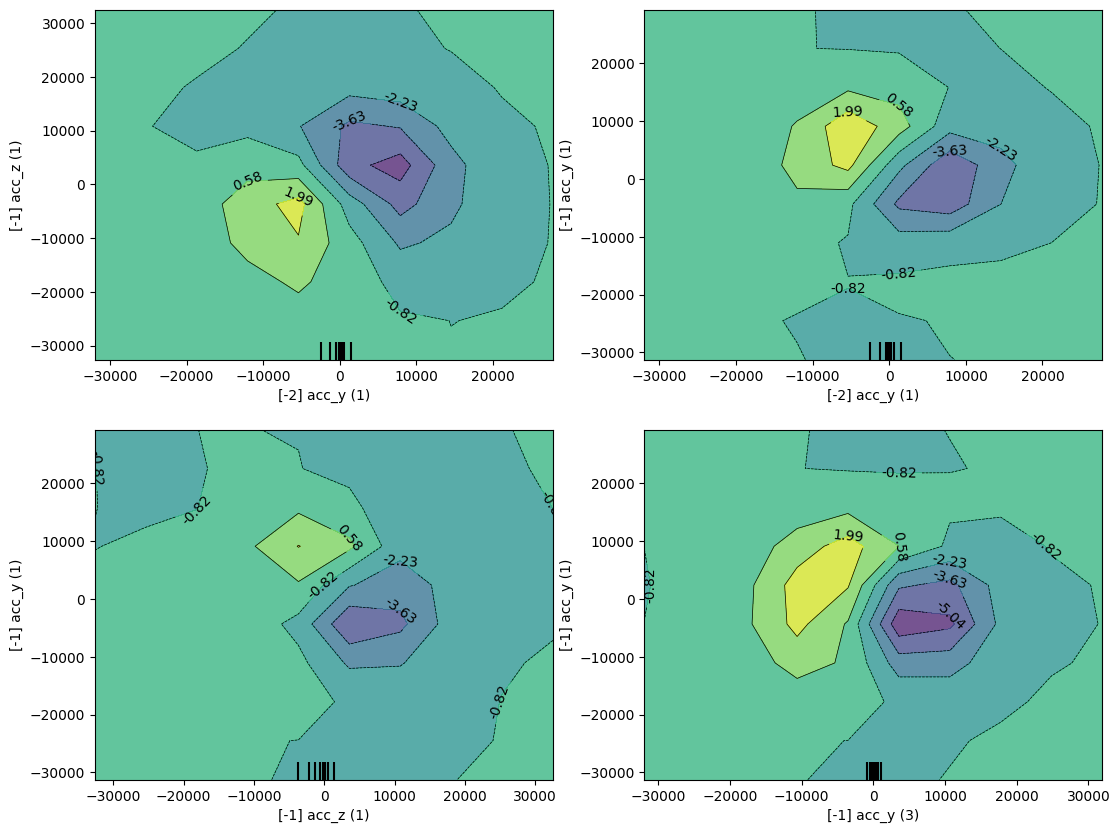

In [61]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [13, 10]

features = [(7, 44), (7, 43), (44, 43), (55, 43)]
display = PartialDependenceDisplay.from_estimator(
    best_model, X_test, features,
    feature_names = FEATURE_NAMES,
    grid_resolution = 10,
    percentiles = (0,1),
    n_cols = 2,
    n_jobs = -1,
    verbose = 4
)

Here is an overview of the impact of all features coming from the finger that is actually clicking. You can quite easily see how the features are used to predict an outcome:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  18 | elapsed:   17.2s remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:   17.5s remaining:   27.5s
[Parallel(n_jobs=-1)]: Done  12 out of  18 | elapsed:   17.6s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   23.5s finished


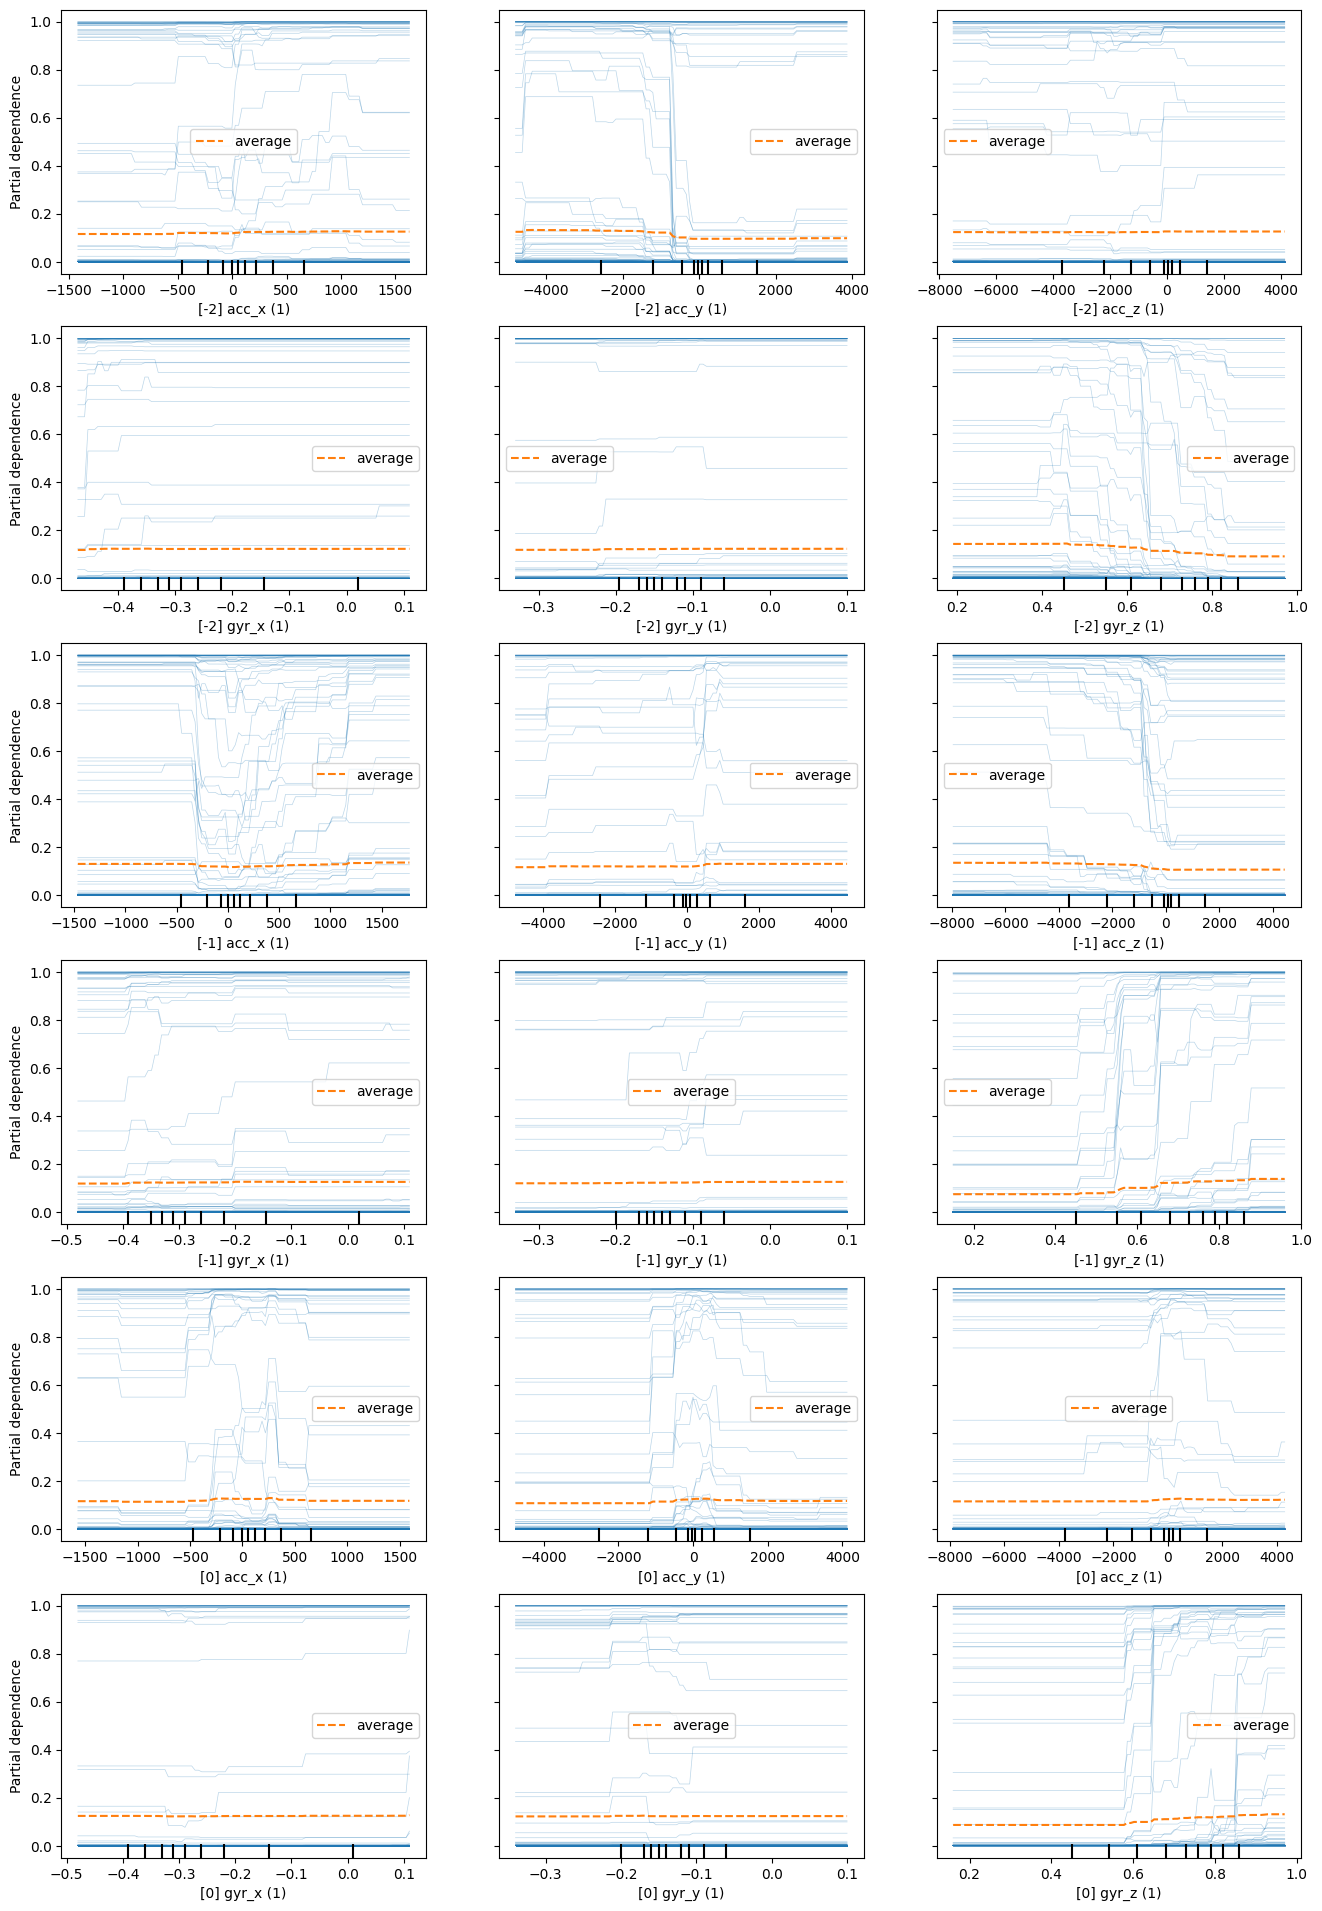

In [45]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 24] # 8.268 x 11.693

features = np.arange(6)+6
features = np.hstack([features, features+36, features+72])

display = PartialDependenceDisplay.from_estimator(
    best_model, X_test, features,
    feature_names = FEATURE_NAMES,
    grid_resolution = 100,
    percentiles = (0.01,0.99),
    n_cols = 3,
    n_jobs = -1,
    verbose = 4,
    kind="both",
    subsample = 200
)

To verify these results we will try to a model with just these for features:

In [84]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

selected_features = np.array([7, 43, 44, 80])

X_red = X[:,selected_features]

X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(
    X_red, y, test_size = 0.33, random_state=42
)

sclf = make_pipeline(StandardScaler(), SVC(C=100, class_weight={1:2}))
sclf.fit(X_red_train, y_red_train)

(recall_score(y_red_test, sclf.predict(X_red_test)),
 precision_score(y_red_test, sclf.predict(X_red_test)),
 f1_score(y_red_test, sclf.predict(X_red_test)))

(0.7728119180633147, 0.5375647668393783, 0.6340718105423988)

## UMAP

https://umap-learn.readthedocs.io/en/latest/parameters.html

UMAP reduces the dimensionality to 2D to give some insights and intuition into how the data might be separable.

In [31]:
import umap

reducer = umap.UMAP()

embedding = reducer.fit_transform(X, y)
embedding.shape

(14090, 2)

This 2D embedding can be visualized as a plot:

Text(0.5, 1.0, 'UMAP projection')

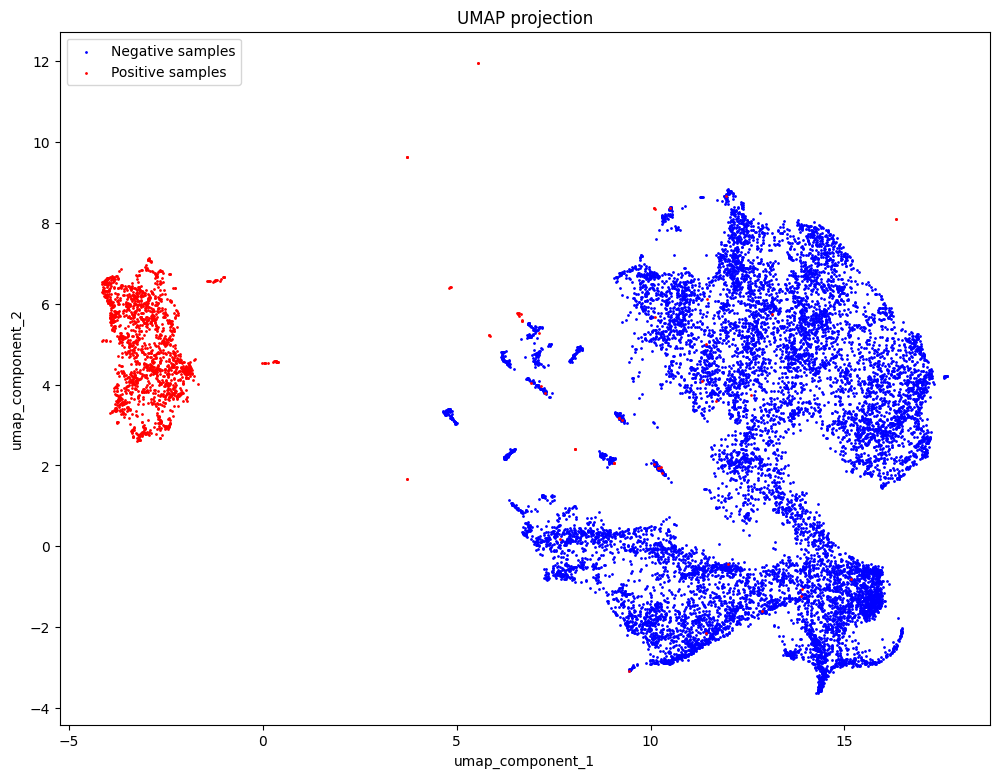

In [32]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 9]

plt.scatter(embedding[y==0,0], embedding[y==0,1], c="blue", s=1, label="Negative samples")
plt.scatter(embedding[y==1,0], embedding[y==1,1], c="red", s=1, label="Positive samples")

plt.legend(loc="upper left")
plt.xlabel(reducer.get_feature_names_out()[0])
plt.ylabel(reducer.get_feature_names_out()[1])
plt.title("UMAP projection")

In [36]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, TSNE

pca = TSNE(n_components=2, n_jobs=-1)

embedding = pca.fit_transform(X, y)
embedding.shape

(14090, 2)

Text(0.5, 1.0, 'Projection')

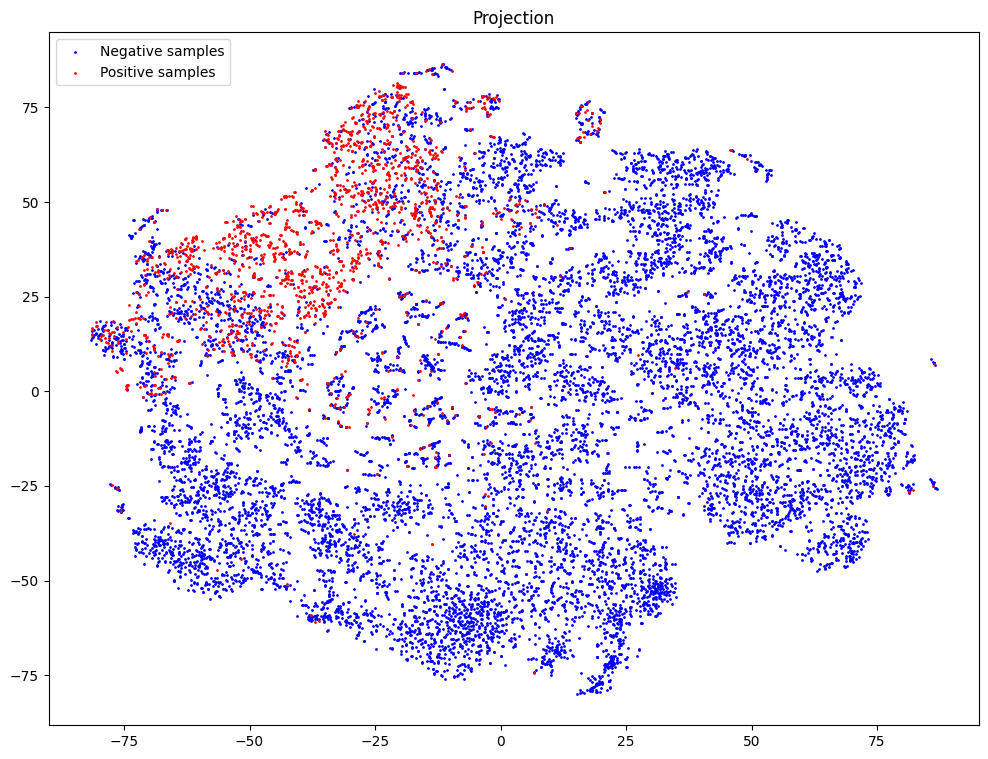

In [37]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 9]

plt.scatter(embedding[y==0,0], embedding[y==0,1], c="blue", s=1, label="Negative samples")
plt.scatter(embedding[y==1,0], embedding[y==1,1], c="red", s=1, label="Positive samples")

plt.legend(loc="upper left")
# plt.xlabel(reducer.get_feature_names_out()[0])
# plt.ylabel(reducer.get_feature_names_out()[1])
plt.title("Projection")